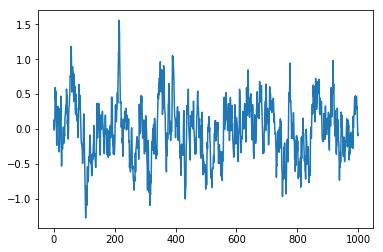

Simulation Started at:
2019-10-23 16:21:58.679894


/home/at-lab/anaconda3/envs/Python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:305: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


0
40
80
120
160
200
240
280
320
360
400
440
480
520
560
600
640
680
720
760
800
840
880
920
960
1000
1040
1080
1120
1160
1200
1240
1280
1320
1360
1400
1440
1480
1520
1560
1600
1640
1680
1720
1760
1800
1840
1880
1920
1960
2000
2040
2080
2120
2160
2200
2240
2280
2320
2360
2400
2440
2480

 
Completed episodes
Simulation Ended at:
2019-10-24 13:49:40.410093


In [29]:
################# Buffer #################
from __future__ import division

import numpy as np
import random
from collections import deque

import numpy as np
import torch
from torch.autograd import Variable
import os
import psutil
import gc
from random import randrange, uniform

import datetime

#from __future__ import division
#import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import math

#import numpy as np
#import torch
import shutil
#import torch.autograd as Variable

import random
from random import randrange, uniform

import scipy.integrate as integrate
from scipy.integrate import quad
from math import pow
import matplotlib.pyplot as plt
    
#import torch
#import torch.nn as nn
#import torch.nn.functional as F
#import numpy as np

class MemoryBuffer:

    def __init__(self, size):
                    self.buffer = deque(maxlen=size)
                    self.maxSize = size
                    self.len = 0

    def sample(self, count = 100):
        
        """
        samples a random batch from the replay memory buffer
        :param count: batch size
        :return: batch (numpy array)
        """
        batch = []
        count = min(count, self.len)
        batch = random.sample(self.buffer, count)

        s_arr = np.array([arr[0] for arr in batch])
        a_arr = np.array([arr[1] for arr in batch])
        #print('\nbatch in sampling',batch)#np.float32
        r_arr = np.array([arr[2] for arr in batch])
        s1_arr = np.array([arr[3] for arr in batch])
        return s_arr, a_arr, r_arr, s1_arr

    def len(self):
        return self.len

    def add(self, s, a, r, s1):
        """
        adds a particular transaction in the memory buffer
        :param s: current state
        :param a: action taken
        :param r: reward received
        :param s1: next state
        :return:
        """
        transition = (s,a,r,s1)
        self.len += 1
        if self.len > self.maxSize:
            self.len = self.maxSize
        self.buffer.append(transition)
        

############## Actor Critic Model ###############



EPS = 0.003

def fanin_init(size, fanin=None):
	fanin = fanin or size[0]
	v = 1. / np.sqrt(fanin)
	return torch.Tensor(size).uniform_(-v, v)

class Critic(nn.Module):

	def __init__(self, state_dim, action_dim):
		"""
		:param state_dim: Dimension of input state (int)
		:param action_dim: Dimension of input action (int)
		:return:
		"""
		super(Critic, self).__init__()

		self.state_dim = state_dim
		self.action_dim = action_dim

		self.fcs1 = nn.Linear(state_dim,7)
		self.fcs1.weight.data = fanin_init(self.fcs1.weight.data.size())
		#self.fcs1_bn = nn.BatchNorm1d(10)  
        
		self.fcs2 = nn.Linear(7,12)
		self.fcs2.weight.data = fanin_init(self.fcs2.weight.data.size())
		#self.fcs2_bn = nn.BatchNorm1d(16)
        
		self.fca1 = nn.Linear(action_dim,12)
		self.fca1.weight.data = fanin_init(self.fca1.weight.data.size())
		#self.fca1_bn = nn.BatchNorm1d(16)
        
		self.fc2 = nn.Linear(24,8)
		self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
		#self.fc2_bn = nn.BatchNorm1d(16)
        
		self.fc3 = nn.Linear(8,1)
		self.fc3.weight.data.uniform_(-EPS,EPS)

	def forward(self, state, action):
		"""
		returns Value function Q(s,a) obtained from critic network
		:param state: Input state (Torch Variable : [n,state_dim] )
		:param action: Input Action (Torch Variable : [n,action_dim] )
		:return: Value function : Q(S,a) (Torch Variable : [n,1] )
		"""
		##print("\nsstate in before fwd",state.size(),"action in before fwd",action.size())
		s1 = F.relu(self.fcs1(state))
		s2 = F.relu(self.fcs2(s1))
		a1 = F.relu(self.fca1(action))
		#print("\ns2 in fwd",s2.size(),"a1 in fwd",a1.size())
		x = torch.cat((s2,a1),dim=1)
		#print('\nx after cat',x.size())
		x = F.relu(self.fc2(x))
		x = self.fc3(x)
		#x = (x - min_action)/(max_action - min_action)
		#print('\nQ value', x)
		return x


class Actor(nn.Module):

	def __init__(self, state_dim, action_dim): #, action_lim
		"""
		:param state_dim: Dimension of input state (int)
		:param action_dim: Dimension of output action (int)
		:param action_lim: Used to limit action in [-action_lim,action_lim]
		:return:
		"""
		super(Actor, self).__init__()

		self.state_dim = state_dim
		self.action_dim = action_dim
		#self.action_lim = action_lim

		self.fc1 = nn.Linear(state_dim,7)
		self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
		#self.fc1_bn = nn.BatchNorm1d(10)
		self.fc2 = nn.Linear(7,12)
		self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
		#self.fc2_bn = nn.BatchNorm1d(16)
		self.fc3 = nn.Linear(12,5)
		self.fc3.weight.data = fanin_init(self.fc3.weight.data.size())
		#self.fc3_bn = nn.BatchNorm1d(6)
		self.fc4 = nn.Linear(5,action_dim)
		self.fc4.weight.data.uniform_(-EPS,EPS)
		
        
	def forward(self, state):
		"""
		returns policy function Pi(s) obtained from actor network
		this function is a gaussian prob distribution for all actions
		with mean lying in (-1,1) and sigma lying in (0,1)
		The sampled action can , then later be rescaled
		:param state: Input state (Torch Variable : [n,state_dim] )
		:return: Output action (Torch Variable: [n,action_dim] )
		"""
		#x = state
		x = F.relu(self.fc1(state))
		x = F.relu(self.fc2(x))
		x = F.relu(self.fc3(x))
		#x = F.relu(self.fc1(state))        
		#x = F.relu(self.fc2(self.fc1_bn(x)))
		#x = F.relu(self.fc3(self.fc2_bn(x)))
		action = F.relu(self.fc4(x))
		m = nn.Sigmoid()
		action = m(action)
		#action = action * self.action_lim

		return action
    
    
    

############ Train ###########



#import utils
#import model

BATCH_SIZE = 128
LEARNING_RATE = 0.002
GAMMA = 0.99
TAU = 0.001
#Loss_Critic = []
#Loss_Actor = []

class Trainer:

	def __init__(self, state_dim, action_dim, ram): #, self.action_lim
		"""
		:param state_dim: Dimensions of state (int)
		:param action_dim: Dimension of action (int)
		:param action_lim: Used to limit action in [-action_lim,action_lim]
		:param ram: replay memory buffer object
		:return:
		"""
		self.state_dim = state_dim
		self.action_dim = action_dim
		#self.action_lim = action_lim
		self.ram = ram
		self.iter = 0
		self.noise = OrnsteinUhlenbeckActionNoise(self.action_dim)

		self.actor = Actor(self.state_dim, self.action_dim) # , self.action_lim
		self.target_actor = Actor(self.state_dim, self.action_dim) #, self.action_lim
		self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),LEARNING_RATE)

		self.critic = Critic(self.state_dim, self.action_dim)
		self.target_critic = Critic(self.state_dim, self.action_dim)
		self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),LEARNING_RATE)

		hard_update(self.target_actor, self.actor)
		hard_update(self.target_critic, self.critic)
		
        
	def get_exploitation_action(self, state):
		"""
		gets the action from target actor added with exploration noise
		:param state: state (Numpy array)
		:return: sampled action (Numpy array)
		"""
		
		action = self.target_actor.forward(state).detach()
		#print('\nExploitation action',action)
		return action.data.numpy()

		        
		        
	def get_exploration_action(self, state):
		"""
		gets the action from actor added with exploration noise
		:param state: state (Numpy array)
		:return: sampled action (Numpy array)
		"""
		#state = [state_0, state_1, state_2, state_3, state_4]
		action = self.actor.forward(state).detach()
		#print(action)        
		new_action = action.data.numpy() + (self.noise.sample()) # * self.action_lim)  
		#print('\nExploration action', new_action)        
		return new_action

	def optimize(self):
		"""
		Samples a random batch from replay memory and performs optimization
		:return:
		"""
		#global loss_critic, loss_actor
        
		s1,a1,r1,s2 = self.ram.sample(BATCH_SIZE)
		#print('\ns1 in optim',s1.shape(),'a1 in optim',a1.shape())

		s1 = torch.from_numpy(s1).float() #s1 = torch.Tensor(s1).float() #Variable(torch.from_numpy(s1))
		a1 = torch.from_numpy(a1).float() #a1 = torch.Tensor(a1).float()
		r1 = torch.from_numpy(r1).float() #r1 = torch.Tensor(r1).float()
		s2 = torch.from_numpy(s2).float() #s2 = torch.Tensor(s2).float()
		#print('\ns1 in optim after conv',s1.size(),'a1 in optim after conv',a1.size())

		# ---------------------- optimize critic ----------------------
		# Use target actor exploitation policy here for loss evaluation
		#print('s2 before trg actor fwd',s2)        
		a2 = self.target_actor.forward(s2).detach()
		next_val = torch.squeeze(self.target_critic.forward(s2, a2).detach())
		# y_exp = r + gamma*Q'( s2, pi'(s2))
		y_expected = r1 + GAMMA*next_val
		# y_pred = Q( s1, a1)
        
		#print('\naction shape problem', a1)        
		y_predicted = torch.squeeze(self.critic.forward(s1, a1))
		#print('\nforward done')        
		# compute critic loss, and update the critic
		loss_critic = F.smooth_l1_loss(y_predicted, y_expected)
		#print('\n Critic Loss ', loss_critic)
		#Loss_Critic.append(loss_critic)
		#torch.save(Loss_Critic, 'Loss_Critic.pt')

		self.critic_optimizer.zero_grad()
		loss_critic.backward()
		self.critic_optimizer.step()

		# ---------------------- optimize actor ----------------------
		pred_a1 = self.actor.forward(s1)
		loss_actor = -1 * torch.sum(self.critic.forward(s1, pred_a1))
		#Loss_Actor.append(loss_actor)
		#torch.save(Loss_Actor, 'Loss_Actor.pt')



		#print(loss_actor)        
		self.actor_optimizer.zero_grad()
		loss_actor.backward()
		self.actor_optimizer.step()

		soft_update(self.target_actor, self.actor, TAU)
		soft_update(self.target_critic, self.critic, TAU)

		# if self.iter % 100 == 0:
		# 	print 'Iteration :- ', self.iter, ' Loss_actor :- ', loss_actor.data.numpy(),\
		# 		' Loss_critic :- ', loss_critic.data.numpy()
		# self.iter += 1
	#def losses(loss_actor, loss_critic):
		#A = loss_actor
		#B = loss_critic
		#return A, B
    #C,D = 
	def save_models(self, episode_count, path_target, path_critic):
		"""
		saves the target actor and critic models
		:param episode_count: the count of episodes iterated
		:return:
		"""
		        
		torch.save(self.target_actor.state_dict(),  path_target )#, 'C:\Users\hp\Desktop\Python DDPG') #'./Models/' + str(episode_count) + '_actor.pt'
		torch.save(self.target_critic.state_dict(), path_critic)#, 'C:\Users\hp\Desktop\Python DDPG') #'./Models/' + str(episode_count) + '_critic.pt'
		#print ('Models saved successfully')
		#retrn
	def load_models(self, episode):
		"""
		loads the target actor and critic models, and copies them onto actor and critic models
		:param episode: the count of episodes iterated (used to find the file name)
		:return:
		"""
		self.actor.load_state_dict(torch.load('./Models/' + str(episode) + '_actor.pt'))
		self.critic.load_state_dict(torch.load('./Models/' + str(episode) + '_critic.pt'))
		hard_update(self.target_actor, self.actor)
		hard_update(self.target_critic, self.critic)
		#print('Models loaded succesfully')
        
        


        
################# Utils #################



def soft_update(target, source, tau):
	"""
	Copies the parameters from source network (x) to target network (y) using the below update
	y = TAU*x + (1 - TAU)*y
	:param target: Target network (PyTorch)
	:param source: Source network (PyTorch)
	:return:
	"""
	for target_param, param in zip(target.parameters(), source.parameters()):
		target_param.data.copy_(
			target_param.data * (1.0 - tau) + param.data * tau
		)


def hard_update(target, source):
	"""
	Copies the parameters from source network to target network
	:param target: Target network (PyTorch)
	:param source: Source network (PyTorch)
	:return:
	"""
	for target_param, param in zip(target.parameters(), source.parameters()):
			target_param.data.copy_(param.data)


def save_training_checkpoint(state, is_best, episode_count):
	"""
	Saves the models, with all training parameters intact
	:param state:
	:param is_best:
	:param filename:
	:return:
	"""
	filename = str(episode_count) + 'checkpoint.path.rar'
	torch.save(state, filename)
	if is_best:
		shutil.copyfile(filename, 'model_best.pth.tar')


# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckActionNoise:

	def __init__(self, action_dim, mu = 0, theta = 0.15, sigma = 0.2):
		self.action_dim = action_dim
		self.mu = mu
		self.theta = theta
		self.sigma = sigma
		self.X = np.ones(self.action_dim) * self.mu

	def reset(self):
		self.X = np.ones(self.action_dim) * self.mu

	def sample(self):
		dx = self.theta * (self.mu - self.X)
		dx = dx + self.sigma * np.random.randn(len(self.X))
		self.X = self.X + dx
		return self.X


# use this to plot Ornstein Uhlenbeck random motion
if __name__ == '__main__':
	ou = OrnsteinUhlenbeckActionNoise(1)
	states = []
	for i in range(1000):
		states.append(ou.sample())


	plt.plot(states)
	plt.show()
    
    
    
    
################################### ENVIRONMENT ############################################


# Variable Declaration before 
Silo_Filllevel_1 = 11.6133
Silo_Filllevel_2 = 11.6133
Silo_Filllevel_3 = 11.6133

Hopper_Filllevel_1 = 4.55
Hopper_Filllevel_2 = 0
Hopper_Filllevel_3 = 0

if Silo_Filllevel_1 >= 1:
    Silo_Empty_1 = 1
else:
    Silo_Empty_1 = 0
            
if Silo_Filllevel_2 >= 1:
    Silo_Empty_2 = 1
else:
    Silo_Empty_2 = 0
          
if Silo_Filllevel_3 >= 1:
    Silo_Empty_3 = 1
else:
    Silo_Empty_3 = 0
    
if Hopper_Filllevel_1 >= 1:
    Hopper_Empty_1 = 1
else:
    Hopper_Empty_1 = 0
            
if Hopper_Filllevel_2 >= 1:
    Hopper_Empty_2 = 1
else:
    Hopper_Empty_2 = 0
            
if Hopper_Filllevel_3 >= 1:
    Hopper_Empty_3 = 1
else:
    Hopper_Empty_3 = 0

VP_Prev_2 = 0
VP_Prev_3 = 0

Rising_2 = 0
Falling_2 = 0
Rising_3 = 0
Falling_3 = 0

Q_Flip_2 = 0
Q_Flip_3 = 0

Q_Flip_Prev_2 = 0
Q_Flip_Prev_3 = 0

Saturator_2 = 0
Saturator_3 = 0

MF_S_H_1 = 0
MF_S_H_2 = 0
MF_S_H_3 = 0

MF_VC_2 = 0
MF_VC_3 = 0

Energy_Conveyor_Sim = 0
Energy_VC_2_Sim = 0
Energy_Vibration_Belt_Sim = 0
Energy_VC_3_Sim = 0
Energy_Rotary_Air_Lock_Sim = 0

Silo_Fill_1_Error = []
Time = []
###########
Conveyor_Motor_Speed = 0
Vibration_Belt_Start = 1
Dosing_Speed = 600
Demand = 50

VP_2 = 0
VP_3 = 1

VP_Time_2 = 10
VP_Time_3 = 10

Exchanged_Mass_Sim = 0
Exchanged_Mass_Sim_Prev = 0
reward_1 = 0
reward_2 = 0
reward_3 = 0
reward_4 = 0
reward_5 = 0

Total_Reward_1 = 0
Total_Reward_2 = 0
Total_Reward_3 = 0
Total_Reward_4 = 0
Total_Reward_5 = 0
Total_Reward_6 = 0



#################### Initial State for an episode ###################


#if action_counter == 1:
def initial_state():
    
    global Silo_Filllevel_1, Silo_Filllevel_2, Silo_Filllevel_3, Hopper_Filllevel_1, Hopper_Filllevel_2, Hopper_Filllevel_3
    global Silo_Empty_1, Hopper_Empty_1, Q_Flip_2, Q_Flip_3, Q_Flip_Prev_2, Q_Flip_Prev_3, Saturator_2, Saturator_3
    global VP_Prev_2, VP_Prev_3
    
    Silo_Filllevel_1 = uniform(0,11.42)
    Silo_Filllevel_2 = uniform(0,11.42)
    Silo_Filllevel_3 = uniform(0,11.42)
    
    Hopper_Filllevel_1 = uniform(0,9.1)
    Hopper_Filllevel_2 = uniform(0,9.1)
    Hopper_Filllevel_3 = uniform(0,9.1)
    
    if Silo_Filllevel_1 >= 1:
        Silo_Empty_1 = 1
    else:
        Silo_Empty_1 = 0
            
    if Silo_Filllevel_2 >= 1:
        Silo_Empty_2 = 1
    else:
        Silo_Empty_2 = 0
          
    if Silo_Filllevel_3 >= 1:
        Silo_Empty_3 = 1
    else:
        Silo_Empty_3 = 0
    
    if Hopper_Filllevel_1 >= 1:
        Hopper_Empty_1 = 1
    else:
        Hopper_Empty_1 = 0
            
    if Hopper_Filllevel_2 >= 1:
        Hopper_Empty_2 = 1
    else:
        Hopper_Empty_2 = 0
            
    if Hopper_Filllevel_3 >= 1:
        Hopper_Empty_3 = 1
    else:
        Hopper_Empty_3 = 0
    
    VP_Prev_2 = randrange(0,2)
    VP_Prev_3 = randrange(0,2)

    Rising_2 = randrange(0,2)
    Falling_2 = randrange(0,2)
    Rising_3 = randrange(0,2)
    Falling_3 = randrange(0,2)

    Q_Flip_2 = randrange(0,2)
    Q_Flip_3 = randrange(0,2)

    Q_Flip_Prev_2 = randrange(0,2)
    Q_Flip_Prev_3 = randrange(0,2)

    Saturator_2 = randrange(0,2)
    Saturator_3 = randrange(0,2)
    
    

############### State Space Reset ################

def state_space_reset():
    global Energy_Conveyor_Sim, Energy_Vibration_Belt_Sim, Energy_VC_2_Sim, Energy_VC_3_Sim, Energy_Rotary_Air_Lock_Sim
    global reward_1, reward_2, reward_3, Total_Reward_1, Total_Reward_2, Total_Reward_3, Demand, Total_Energy_Sim, Exchanged_Mass_Sim, Total_Energy_Sim_Prev, reached
    global sum_of_actor_loss_1, sum_of_critic_loss_1,sum_of_actor_loss_2, sum_of_critic_loss_2,sum_of_actor_loss_3, sum_of_critic_loss_3,sum_of_actor_loss_4, sum_of_critic_loss_4,sum_of_actor_loss_5, sum_of_critic_loss_5
    global Total_Reward_4, Total_Reward_5, Total_Reward_6, Exchanged_Mass_Sim_Prev
    Exchanged_Mass_Sim = 0
    Total_Energy_Sim_Prev = 0
    Exchanged_Mass_Sim_Prev = 0
    Energy_Conveyor_Sim = 0                
    Energy_VC_2_Sim = 0
    Energy_Vibration_Belt_Sim = 0
    Energy_VC_3_Sim = 0
    Energy_Rotary_Air_Lock_Sim = 0
    Total_Energy_Sim = 0
    reached = 0   
    Total_Reward_1 = 0
    Total_Reward_2 = 0
    Total_Reward_3 = 0
    Total_Reward_4 = 0
    Total_Reward_5 = 0
    Total_Reward_6 = 0
    reward_1 = 0
    reward_2 = 0
    reward_3 = 0
    Demand = 0
    Energy_Episode = 0
    sum_of_actor_loss_1 = 0
    sum_of_critic_loss_1 = 0
    sum_of_actor_loss_2 = 0
    sum_of_critic_loss_2 = 0
    sum_of_actor_loss_3 = 0
    sum_of_critic_loss_3 = 0
    sum_of_actor_loss_4 = 0
    sum_of_critic_loss_4 = 0
    sum_of_actor_loss_5 = 0
    sum_of_critic_loss_5 = 0
    
    
    
    
############################################# ENVIRONMENT ##############################################
########################################################################################################

##### The below lines of code are for the NN to realize the working ranges of various variables #####
def learning_action_range():
    
    global Conveyor_Motor_Speed, Vibration_Belt_Start, VP_2, VP_Time_2, VP_3, VP_Time_3, Dosing_Speed, Demand
    global reward_1, reward_2, reward_3
    
    if Conveyor_Motor_Speed >  1850 or Conveyor_Motor_Speed < 450:
        reward_1 = -30  
        reward_2 = -30 
        reward_3 = -30
    elif Vibration_Belt_Start != 0 or Vibration_Belt_Start != 1:
        reward_1 = -30  
        reward_2 = -30  
        reward_3 = -30
    elif VP_Time_2 > 10 or VP_Time_2 < 0:
        reward_1 = -30  
        reward_2 = -30  
        reward_3 = -30
    elif VP_Time_3 > 10 or VP_Time_3 < 0:
        reward_1 = -30 
        reward_2 = -30 
        reward_3 = -30
    elif Dosing_Speed > 1500 or Dosing_Speed < 450:
        reward_1 = -30  
        reward_2 = -30 
        reward_3 = -30
    elif Demand > 100:
        reward_1 = -30 
        reward_2 = -30 
        reward_3 = -30
    else:
        pass
    
    
    
    
    
######################################### BULK GOOD SYSTEM #####################################

def environment_bgs():
    
    global Silo_Filllevel_1, Silo_Filllevel_2, Silo_Filllevel_3, Hopper_Filllevel_1, Hopper_Filllevel_2, Hopper_Filllevel_3
    global MF_VC_2, MF_VC_3,Demand, Total_Energy_Sim_Prev, Exchanged_Mass_Sim_Prev
    global Energy_Conveyor_Sim, Energy_VC_2_Sim, Energy_Vibration_Belt_Sim, Energy_VC_3_Sim, Energy_Rotary_Air_Lock_Sim
    global VP_2, VP_3, VP_Time_2, VP_Time_3, MF_S_H_1, MF_S_H_2, MF_S_H_3
    global Silo_Empty_1, Hopper_Empty_1, Q_Flip_2, Q_Flip_3, Q_Flip_Prev_2, Q_Flip_Prev_3, Saturator_2, Saturator_3
    global VP_Prev_2, VP_Prev_3, Exchanged_Mass_Sim, reward_1, reward_2, reward_3, reward_4, reward_5, reward_6,  reached
    global Total_Reward_1, Total_Reward_2, Total_Reward_3, Total_Reward_4, Total_Reward_5, Total_Reward_6, Demand
    
    bigloop = 0
    t = 0
    while bigloop <=100:  # 10 secs

        ##################### Station 1 #####################

        #### Substation 1 - Conveyor Belt - RPM to Mass flow ####


        # Massflow Silo to Hopper

        # Silo Empty
        #Silo_Filllevel_1 = uniform(0,11.42)
        #### SILO_STATE ######
        if Silo_Filllevel_1 >= 1:
            Silo_Empty_1 = 1
        else:
            Silo_Empty_1 = 0
        
        ######################

        MF_S_H_1 = Conveyor_Motor_Speed * 0.01 / 60 * Silo_Empty_1

        cms = Conveyor_Motor_Speed

        # Energy - Conveyor Belt

        f_cms = lambda x: Conveyor_Motor_Speed*(-81.0493 + 0.5558316*cms - 0.0008993839*cms**2 + 6.578498e-7*cms**3 - 2.197611e-10*cms**4 + 2.721772e-14*cms**5)/(60*1000)
        energy,err = integrate.quad(f_cms,t,t+0.1)

        Energy_Conveyor_Sim = Energy_Conveyor_Sim +  energy

        #### Substation 2 - Silo ####

        # Silo Fill level

        f_sfl_1 = lambda x: MF_S_H_1 * (-1)
        fill,err = integrate.quad(f_sfl_1,t,t+0.1)

        #torch.save(Silo_Fill_1_Error, 'Silo_Fill_1_Error.pt')

        Silo_Filllevel_1 = Silo_Filllevel_1 + fill
        #Mass_Silo_1 = Mass_Silo_1 + fill
        
        #Silo_Fill_1_Error.append(Silo_Filllevel_1)

        if Silo_Filllevel_1 >= 17.42:
            Silo_Filllevel_1 = 17.42
        elif Silo_Filllevel_1 <= 0:
            Silo_Filllevel_1 = 0

        # Silo Empty

        if Silo_Filllevel_1 >= 1:
            Silo_Empty_1 = 1
        else:
            Silo_Empty_1 = 0

        #### Substation 3 - Hopper ####

        # Hopper Fill level
        f_hfl_1 = lambda x: (MF_S_H_1 - MF_VC_2)

        fill, err = integrate.quad(f_hfl_1, t, t+0.1)
        Hopper_Filllevel_1 = Hopper_Filllevel_1 + fill

        if Hopper_Filllevel_1 >= 9.4:
            Hopper_Filllevel_1 = 9.4
        elif Hopper_Filllevel_1 <= 0:
            Hopper_Filllevel_1 = 0

        # Hopper Empty

        if Hopper_Filllevel_1 >= 1:
            Hopper_Empty_1 = 1
        else:
            Hopper_Empty_1 = 0

        ##################### Station 2 ##################### 

        #### Substation 1 - Vacuum Pump ####

        # Massflow - Previous Hopper to Silo

        if t >= VP_Time_2:
            VP_2 = 0
        else:
            VP_2 = 1
        
        if VP_2 - VP_Prev_2 > 0:              # To know if the quantity of material is rising or falling in the VP
            Rising_2 = 1
            Falling_2 = 0     
        elif VP_2 - VP_Prev_2 <0:             #
            Rising_2 = 0 
            Falling_2 = 1     #
        else:                                  #
            Rising_2 = 0 
            Falling_2 = 0     #

        VP_Prev_2 = VP_2

        if Rising_2 == 0 and Falling_2 == 0:    # SR Flip-Flop equivalent
            Q_Flip_2 = Q_Flip_Prev_2
        elif Rising_2 == 0 and Falling_2 == 1:
            Q_Flip_2 = 1
        elif Rising_2 == 1 and Falling_2 == 0:
            Q_Flip_2 = 0
        elif Rising_2 == 1 and Falling_2 == 1:
            Q_Flip_2 = 0

        Q_Flip_Prev_2 = Q_Flip_2

        if Q_Flip_2 == 0:
            MF_VC_2 = 0
        elif Q_Flip_2 == 0:
            Saturator_2 = t - 0.567

        if Saturator_2 >= 4.575:
            Saturator_2 = 4.575
        elif Saturator_2 <= 0:
            Saturator_2 = 0


        MF_VC_2 = ((0.0664 * Saturator_2) + 0.464) * (Hopper_Empty_1)

        # Energy - Vacuum Pump

        f_vp_2 = lambda x: (VP_2 * 0.305)

        energy,err = integrate.quad(f_vp_2, t, t+0.1)

        Energy_VC_2_Sim = Energy_VC_2_Sim + energy

        #### Substation 2- Vibration Belt ####

        # Massflow Silo to Hopper

        # Silo Empty

        if Silo_Filllevel_2 >= 1:
            Silo_Empty_2 = 1
        else:
            Silo_Empty_2 = 0

        MF_S_H_2 = Vibration_Belt_Start * 0.4 * Silo_Empty_2

        # Energy Vibration Belt

        f_env = lambda x: (26.9 * Vibration_Belt_Start / 1000)
        energy, err = integrate.quad(f_env,t,t+0.1)

        Energy_Vibration_Belt_Sim = Energy_Vibration_Belt_Sim + energy

        #### Substation 3 - Silo ####

        # Silo Fill level

        f_sfl_2 = lambda x: (MF_VC_2 - MF_S_H_2)
        fill,err = integrate.quad(f_sfl_2,t,t+0.1)

        Silo_Filllevel_2  = Silo_Filllevel_2 + fill
        #Mass_Silo_2 = Mass_Silo_2 + fill

        if Silo_Filllevel_2 >= 17.42:
            Silo_Filllevel_2 = 17.42
        elif Silo_Filllevel_2 <= 0:
            Silo_Filllevel_2 = 0


        # Silo Empty

        if Silo_Filllevel_2 >= 1:
            Silo_Empty_2 = 1
        else:
            Silo_Empty_2 = 0

        #### Substation 3 - Hopper ####

        # Hopper Fill level

        f_hfl_2 = lambda x: (MF_S_H_2 - MF_VC_3)

        fill,err = integrate.quad(f_hfl_2,t,t+0.1)

        Hopper_Filllevel_2 = Hopper_Filllevel_2 + fill

        if Hopper_Filllevel_2 >= 9.4:
            Hopper_Filllevel_2 = 9.4
        elif Hopper_Filllevel_2 <= 0:
            Hopper_Filllevel_2 = 0

        # Hopper Empty

        if Hopper_Filllevel_2 >= 1:
            Hopper_Empty_2 = 1
        else:
            Hopper_Empty_2 = 0


        ##################### Station 3 ##################### 

        #### Substation 1 - Vacuum Pump ####

        if t >= VP_Time_3:
            VP_3 = 0
        else: 
            VP_3 = 0

        if VP_3 - VP_Prev_3 > 0:              # To know if the quantity of material is rising or falling in the VP
            Rising_3 = 1 
            Falling_3 = 0      #
        elif VP_3 - VP_Prev_2 <0:             #
            Rising_3 = 0 
            Falling_3 = 1      #
        elif VP_3 - VP_Prev_3 == 0:            #
            Rising_3 = 0 
            Falling_3 = 0      #

        VP_Prev_3 = VP_3

        if Rising_3 == 0 and Falling_3 == 0:    # SR Flip-Flop equivalent
            Q_Flip_3 = Q_Flip_Prev_3
        elif Rising_3 == 0 and Falling_3 == 1:
            Q_Flip_3 = 1
        elif Rising_3 == 1 and Falling_3 == 0:
            Q_Flip_3 = 0
        elif Rising_3 == 1 and Falling_3 == 1:
            Q_Flip_3 = 0

        Q_Flip_Prev_3 = Q_Flip_3

        if Q_Flip_3 == 0:
            MF_VC_3 = 0
        elif Q_Flip_3 == 0:
            Saturator_3 = t - 0.979

        if Saturator_3 >= 9.5:
            Saturator_3 = 9.5
        elif Saturator_3 <= 0:
            Saturator_3 = 0



        MF_VC_3 = ((0.0192 * Saturator_3) + 0.3535) * (Hopper_Empty_2)

        # Energy - Vacuum Pump

        f_vp_3 = lambda x: (VP_3 * 0.456)

        energy,err = integrate.quad(f_vp_3,t,t+0.1)

        Energy_VC_3_Sim = Energy_VC_3_Sim + energy

        #### Substation 2 - Rotary Air lock ####

        # Massflow Silo to Hopper

        # Silo Empty

        if Silo_Filllevel_3 >= 1:
            Silo_Empty_3 = 1
        else:
            Silo_Empty_3 = 0

        MF_S_H_3 = (Dosing_Speed) * (Silo_Empty_3) * 0.01249 / 60

        # Energy Rotary Air Lock

        f_eral = lambda x: (Dosing_Speed * 370 / (1500 * 1000))

        energy,err = integrate.quad(f_eral,t,t+0.1)

        Energy_Rotary_Air_Lock_Sim = Energy_Rotary_Air_Lock_Sim + energy

        #### Substation 3 - Silo ####

        # Silo Fill level

        f_sfl_3 = lambda x: (MF_VC_3 - MF_S_H_3)
        fill,err = integrate.quad(f_sfl_3,t,t+0.1)

        Silo_Filllevel_3  = Silo_Filllevel_3 + fill
        #Mass_Silo_3 = Mass_Silo_3 + fill

        if Silo_Filllevel_3 >= 17.45:
            Silo_Filllevel_3 = 17.45
        elif Silo_Filllevel_3 <= 0:
            Silo_Filllevel_3 = 0

        # Silo Empty

        if Silo_Filllevel_3 >= 1:
            Silo_Empty_3 = 1
        else:
            Silo_Empty_3 = 0

        #### Substation 3 - Hopper ####

        # Hopper Fill level

        f_hfl_3 = lambda x: (MF_S_H_1 - Demand)

        fill,err = integrate.quad(f_hfl_3,t,t+0.1)
        
        Hopper_Filllevel_3 = Hopper_Filllevel_3 + fill

        if Hopper_Filllevel_3 >= 9.4:
            Hopper_Filllevel_3 = 9.4
        elif Hopper_Filllevel_3 <= 0:
            Hopper_Filllevel_3 = 0
    
        f_demand = lambda x: Demand                      # Overall Mass transported by the system
        dem,err = integrate.quad(f_demand,t,t+0.1)       #
        Exchanged_Mass_Sim = Exchanged_Mass_Sim + dem    #

        # Hopper Empty

        if Hopper_Filllevel_3 >= 1:
            Hopper_Empty_3 = 1
        else:
            Hopper_Empty_3 = 0
        ##########################################################

        t = t + 0.1                             # Next time step 

        bigloop = bigloop + 1
        ################################################################################################################   
    Total_Energy_Sim = sum([Energy_Conveyor_Sim, Energy_VC_2_Sim, Energy_Vibration_Belt_Sim, Energy_VC_3_Sim, Energy_Rotary_Air_Lock_Sim])

    ############ Rewards ###########    

    #### Terminal State ####
    if Exchanged_Mass_Sim >= 150000:
        reward_1 = (1000000 - Energy_Conveyor_Sim)/100
        reward_2 = (1000000 - Energy_VC_2_Sim)/100
        reward_3 = (1000000 - Energy_Vibration_Belt_Sim)/100
        reward_4 = (1000000 - Energy_VC_3_Sim)/100
        reward_5 = (1000000 - Energy_Rotary_Air_Lock_Sim)/100
        reward_6 = (1200000 - Energy_VC_2_Sim - Energy_VC_3_Sim)/100
        
        reached = 1

    else:
        reward_1 = -1
        reward_2 = -1
        reward_3 = -1
        reward_4 = -1
        reward_5 = -1
        reward_6 = -1
        reached = 0
    
    #if steps_in_episode == 2:
     #   Total_Energy_Sim_Prev = Total_Energy_Sim/steps_in_episode
      #  Exchanged_Mass_Sim_Prev = Exchanged_Mass_Sim
        
    if steps_in_episode%30 == 0:
        if steps_in_episode != 0:
            if Total_Energy_Sim/steps_in_episode > Total_Energy_Sim_Prev:
                reward_1 = reward_1 - Energy_Conveyor_Sim/steps_in_episode
                reward_2 = reward_2 - Energy_VC_2_Sim/steps_in_episode
                reward_3 = reward_3 - Energy_Vibration_Belt_Sim/steps_in_episode
                reward_4 = reward_4 - Energy_VC_3_Sim/steps_in_episode
                reward_5 = reward_5 - Energy_Rotary_Air_Lock_Sim/steps_in_episode
                reward_6 = reward_6 - (Energy_VC_2_Sim - Energy_VC_3_Sim)/steps_in_episode
                Total_Energy_Sim_Prev = Total_Energy_Sim/steps_in_episode
                
    if steps_in_episode%30 == 0:
        if steps_in_episode != 0:
            if Exchanged_Mass_Sim/steps_in_episode > Exchanged_Mass_Sim_Prev:
                reward_1 = reward_1 - Exchanged_Mass_Sim_Prev/steps_in_episode
                reward_2 = reward_2 - Exchanged_Mass_Sim_Prev/steps_in_episode
                reward_3 = reward_3 - Exchanged_Mass_Sim_Prev/steps_in_episode
                reward_4 = reward_4 - Exchanged_Mass_Sim_Prev/steps_in_episode
                reward_5 = reward_5 - Exchanged_Mass_Sim_Prev/steps_in_episode
                reward_6 = reward_6 - Exchanged_Mass_Sim_Prev/steps_in_episode
                Exchanged_Mass_Sim_Prev = Exchanged_Mass_Sim/steps_in_episode

    if steps_in_episode >= 488:
        reward_1 = -40
        reward_2 = -40
        reward_3 = -40
        reward_4 = -40
        reward_5 = -40
        reward_6 = -40
    
    Total_Reward_1 = Total_Reward_1 + reward_1
    Total_Reward_2 = Total_Reward_2 + reward_2
    Total_Reward_3 = Total_Reward_3 + reward_3
    Total_Reward_4 = Total_Reward_4 + reward_4
    Total_Reward_5 = Total_Reward_5 + reward_5
    Total_Reward_6 = Total_Reward_6 + reward_6
    
    return Silo_Filllevel_1, Silo_Filllevel_2, Silo_Filllevel_3, Hopper_Filllevel_1, Hopper_Filllevel_2, Hopper_Filllevel_3, Energy_Conveyor_Sim, Energy_VC_2_Sim, Energy_Vibration_Belt_Sim, Energy_VC_3_Sim, Energy_Rotary_Air_Lock_Sim, Total_Energy_Sim, VP_2, VP_3, VP_Time_2, VP_Time_3, MF_VC_2, MF_VC_3, MF_S_H_1, MF_S_H_2, MF_S_H_3, Silo_Empty_1, Hopper_Empty_1, Q_Flip_2, Q_Flip_3, Q_Flip_Prev_2, Q_Flip_Prev_3, Saturator_2, Saturator_3, VP_Prev_2, VP_Prev_3, Exchanged_Mass_Sim, reached, reward_1, reward_2, reward_3, Total_Reward_1, Total_Reward_2, Total_Reward_3, Demand, Total_Energy_Sim 

# 0 Silo_Filllevel_1      # 7 Energy_VC_2_Sim              #14 VP_Time_2    #21 Silo_Empty_1      #28 Saturator_3          #35 reward_3
# 1 Silo_Filllevel_2      # 8 Energy_Vibration_Belt_Sim    #15 VP_Time_3    #22 Hopper_Empty_1    #29 VP_Prev_2            #36 Total_Reward_1
# 2 Silo_Filllevel_3      # 9 Energy_VC_3_Sim              #16 MF_VC_2      #23 Q_Flip_2          #30 VP_Prev_3            #37 Total_Reward_2
# 3 Hopper_Filllevel_1    #10 Energy_Rotary_Air_Lock_Sim   #17 MF_VC_3      #24 Q_Flip_3          #31 Exchanged_Mass_Sim   #38 Total_Reward_1
# 4 Hopper_Filllevel_2    #11 Total_Energy_Sim             #18 MF_S_H_1     #25 Q_Flip_Prev_2     #32 reached              #39 Demand
# 5 Hopper_Filllevel_3    #12 VP_2                         #19 MF_S_H_2     #26 Q_Flip_Prev_3     #33 reward_1             #40 Total_Energy_Sim
# 6 Energy_Conveyor_Sim   #13 VP_3                         #20 MF_S_H_3     #27 Saturator_2       #34 reward_2






############ Main #############


now = datetime.datetime.now()

print
print("Simulation Started at:")
print(str(now))
#import train
#import buffer

MAX_EPISODES = 2500  # Madhav kept it as 2500 states for best result
MAX_STEPS = 550
MAX_BUFFER = 100000

Energy_Consumed_Per_Episode = []
Episode_counter = []
Terminal_reached = []
Reward_Per_Episode_1 = []
Reward_Per_Episode_2 = []
Reward_Per_Episode_3 = []
Reward_Per_Episode_4 = []
Reward_Per_Episode_5 = []
Reward_Per_Episode_6 = []
Actor_loss_per_episode_1 = []
Critic_loss_per_episode_1 = []
Actor_loss_per_episode_2 = []
Critic_loss_per_episode_2 = []
Actor_loss_per_episode_3 = []
Critic_loss_per_episode_3 = []
Actor_loss_per_episode_4 = []
Critic_loss_per_episode_4 = []
Actor_loss_per_episode_5 = []
Critic_loss_per_episode_5 = []


#MAX_TOTAL_REWARD = 300
#S_DIM = env.observation_space.shape[0]
#A_DIM = env.action_space.shape[0]
#A_MAX = env.action_space.high[0]

#print (' State Dimensions :- ', S_DIM)
#print (' Action Dimensions :- ', A_DIM)
#print (' Action Max :- ', A_MAX)

ram_1 = MemoryBuffer(MAX_BUFFER)
ram_2 = MemoryBuffer(MAX_BUFFER)
ram_3 = MemoryBuffer(MAX_BUFFER)
ram_4 = MemoryBuffer(MAX_BUFFER)
ram_5 = MemoryBuffer(MAX_BUFFER)
ram_6 = MemoryBuffer(MAX_BUFFER)

trainer_1 = Trainer(5, 1, ram_1)
trainer_2 = Trainer(5, 1, ram_2) # , A_MAX
trainer_3 = Trainer(5, 1, ram_3) # , A_MAX
trainer_4 = Trainer(5, 1, ram_4) # , A_MAX
trainer_5 = Trainer(5, 1, ram_5) # , A_MAX
trainer_6 = Trainer(5, 1, ram_6) # , A_MAX

for _ep in range(MAX_EPISODES):
    state_space_reset()
    initial_state()
    Demand = uniform(10,50)
    
    for steps_in_episode in range(MAX_STEPS):
        #env.render()
        
        state_1 = [Silo_Filllevel_1/17.42, Hopper_Filllevel_1/9.1, MF_VC_2, ((Demand-10)/40), ((Demand-10)/40)]
        state_2 = [Silo_Filllevel_2/17.42, Hopper_Filllevel_2/9.1, MF_VC_2, MF_VC_3, ((Demand-10)/40)]
        state_3 = [Silo_Filllevel_3/17.42, Hopper_Filllevel_3/9.1, MF_VC_2, MF_VC_3, ((Demand-10)/40)]
        state_space_1 = torch.tensor(state_1).float()
        state_space_2 = torch.tensor(state_2).float()
        state_space_3 = torch.tensor(state_3).float()
        
        if _ep <2000:
            prob = (-0.0445)*_ep + 90
        else:
            prob = 1
                
        randomizer = randrange(0, 101)
        if randomizer < prob:
            Conveyor_Motor_Speed = ((trainer_1.get_exploration_action(state_space_1)) * 1400) + 450
            #print('Conveyor_Motor_Speed', Conveyor_Motor_Speed)
            
            VP__Time_2 = (trainer_2.get_exploration_action(state_space_2)) * 10
            #print('VP__Time_2',VP__Time_2)
            
            Vibration_Belt_Start = trainer_3.get_exploration_action(state_space_2)
            if Vibration_Belt_Start < 0.5:
                Vibration_Belt_Start = 0
            else: Vibration_Belt_Start = 1
            #print('Vibration_Belt_Start',Vibration_Belt_Start)
            
            VP_Time_3 = (trainer_4.get_exploration_action(state_space_3)) * 10
            #print('VP_Time_3',VP_Time_3)
            
            Dosing_Speed = ((trainer_5.get_exploration_action(state_space_3)) * 1050) + 450
            #print('Dosing_Speed',Dosing_Speed)
            
            Demand = ((trainer_6.get_exploration_action(state_space_3)) * 40) + 10
            #print('Demand', Demand)
            #print('\nExplore \n')
            
        else:
            Conveyor_Motor_Speed = ((trainer_1.get_exploitation_action(state_space_1)) * 1400) + 450
            #print('Conveyor_Motor_Speed', Conveyor_Motor_Speed)
            
            VP__Time_2 = (trainer_2.get_exploitation_action(state_space_2)) * 10
            #print('VP__Time_2',VP__Time_2)
            
            Vibration_Belt_Start = trainer_3.get_exploitation_action(state_space_2)
            if Vibration_Belt_Start < 0.5:
                Vibration_Belt_Start = 0
            else: Vibration_Belt_Start = 1
            #print('Vibration_Belt_Start',Vibration_Belt_Start)
            
            VP_Time_3 = (trainer_4.get_exploitation_action(state_space_3)) * 10
            #print('VP_Time_3',VP_Time_3)
            
            Dosing_Speed = ((trainer_5.get_exploitation_action(state_space_3)) * 1050) + 450
            #print('Dosing_Speed',Dosing_Speed)
            
            Demand = ((trainer_6.get_exploitation_action(state_space_3)) * 40) + 10
            #print('Demand', Demand)
            #print('\nExploit \n')
            #print(Conveyor_Motor_Speed, VP_Time_2, VP_Time_3, Dosing_Speed, Vibration_Belt_Start)
            
        #action_1 = trainer_1.get_exploration_action(state)
        # if _ep%5 == 0:
        # 	# validate every 5th episode
        # 	action = trainer.get_exploitation_action(state)
        # else:
        # 	# get action based on observation, use exploration policy here
        # 	action = trainer.get_exploration_action(state)
        #new_observation, reward, done, info = env.step(action)

        new_state = environment_bgs()
        new_Silo_Filllevel_1 = new_state[0]
        new_Silo_Filllevel_2 = new_state[1]
        new_Silo_Filllevel_3 = new_state[2]
        new_Hopper_Filllevel_1 = new_state[3]
        new_Hopper_Filllevel_2 = new_state[4]
        new_Hopper_Filllevel_3 = new_state[5]
        new_MF_VC_2 = new_state[16]
        new_MF_VC_3 = new_state[17]
        new_Demand = Demand
        Total_Energy_Sim = new_state[40]
            
        #print('hi')
            
        new_state_1 = [new_Silo_Filllevel_1, new_Hopper_Filllevel_1, new_MF_VC_2, new_Demand, 0]
        new_state_2 = [new_Silo_Filllevel_2, new_Hopper_Filllevel_2, new_MF_VC_2, new_MF_VC_3, new_Demand]
        new_state_3 = [new_Silo_Filllevel_3, new_Hopper_Filllevel_3, new_MF_VC_2, new_MF_VC_3, new_Demand]
        new_state_space_1 = torch.tensor(new_state_1)
        new_state_space_2 = torch.tensor(new_state_2)
        new_state_space_3 = torch.tensor(new_state_3)
        
            # push this exp in ram
        ram_1.add(state_space_1.tolist(), ((Conveyor_Motor_Speed - 450)/(1400)), reward_1/100, new_state_space_1.tolist())
        ram_2.add(state_space_2.tolist(), [VP_Time_2/10], reward_2/100, new_state_space_2.tolist())
        ram_3.add(state_space_2.tolist(), [Vibration_Belt_Start], reward_3/100, new_state_space_2.tolist())
        ram_4.add(state_space_3.tolist(), VP_Time_3/10, reward_4/100, new_state_space_3.tolist())
        ram_5.add(state_space_3.tolist(), ((Dosing_Speed - 450)/(1050)), reward_5/100, new_state_space_3.tolist())
        ram_6.add(state_space_3.tolist(), ((Dosing_Speed - 450)/(1050)), reward_5/100, new_state_space_3.tolist())
        
        #print(' \n Action counter', r)
        
            # perform optimization
        trainer_1.optimize()
        trainer_2.optimize()        
        trainer_3.optimize()
        trainer_4.optimize()
        trainer_5.optimize()
        
        #C = trainer_1.A
        #D = trainer_1.B
        #E = trainer_2.A
        #F = trainer_2.B
        #G = trainer_3.A
        #H = trainer_3.B
        #I = trainer_4.A
        #J = trainer_4.B
        #K = trainer_5.A
        #L = trainer_5.B
        
        #sum_of_actor_loss_1 = sum_of_actor_loss + C
        #sum_of_critic_loss_1 = sum_of_critic_loss + D
        #sum_of_actor_loss_2 = sum_of_actor_loss + E
        #sum_of_critic_loss_2 = sum_of_critic_loss +  F
        #sum_of_actor_loss_3 = sum_of_actor_loss + G 
        #sum_of_critic_loss_3 = sum_of_critic_loss + H 
        #sum_of_actor_loss_4 = sum_of_actor_loss + I
        #sum_of_critic_loss_4 = sum_of_critic_loss + J 
        #sum_of_actor_loss_5 = sum_of_actor_loss + K
        #sum_of_critic_loss_5 = sum_of_critic_loss + L 
        
        if reached == 1:
            break
        
############################### End of Episode ###################################
        
    Energy_Consumed_Per_Episode.append(Total_Energy_Sim)
    Episode_counter.append(steps_in_episode)
    Terminal_reached.append(reached)
    
    Reward_Per_Episode_1.append(Total_Reward_1)
    Reward_Per_Episode_2.append(Total_Reward_2)
    Reward_Per_Episode_3.append(Total_Reward_3)
    Reward_Per_Episode_4.append(Total_Reward_4)
    Reward_Per_Episode_5.append(Total_Reward_5)
    Reward_Per_Episode_6.append(Total_Reward_6)
    
    #Actor_loss_per_episode_1.append(sum_of_actor_loss_1)
    #Critic_loss_per_episode_1.append(sum_of_critic_loss_1)
    #Actor_loss_per_episode_2.append(sum_of_actor_loss_2)
    #Critic_loss_per_episode_2.append(sum_of_critic_loss_2)
    #Actor_loss_per_episode_3.append(sum_of_actor_loss_3)
    #Critic_loss_per_episode_3.append(sum_of_critic_loss_3)
    #Actor_loss_per_episode_4.append(sum_of_actor_loss_4)
    #Critic_loss_per_episode_4.append(sum_of_critic_loss_4)
    #Actor_loss_per_episode_5.append(sum_of_actor_loss_5)
    #Critic_loss_per_episode_5.append(sum_of_critic_loss_5)
    
    # check memory consumption and clear memory
    gc.collect()
    #print('Episode: ', _ep)
    # process = psutil.Process(os.getpid())
    # print(process.memory_info().rss)
    torch.save(Energy_Consumed_Per_Episode, 'Energy_Consumed_Per_Episode.pt')
    torch.save(Terminal_reached, 'Terminal_reached.pt')
    torch.save(Reward_Per_Episode_1, 'Reward_Per_Episode_1.pt')
    torch.save(Reward_Per_Episode_2, 'Reward_Per_Episode_2.pt')
    torch.save(Reward_Per_Episode_3, 'Reward_Per_Episode_3.pt')
    torch.save(Reward_Per_Episode_4, 'Reward_Per_Episode_4.pt')
    torch.save(Reward_Per_Episode_5, 'Reward_Per_Episode_5.pt')
    torch.save(Reward_Per_Episode_6, 'Reward_Per_Episode_6.pt')
    torch.save(Episode_counter, 'Episode_counter.pt')
    
    #torch.save(Actor_loss_per_episode_1, 'Actor_loss_per_episode_1')
    #torch.save(Critic_loss_per_episode_1, 'Critic_loss_per_episode_1')
    #torch.save(Actor_loss_per_episode_2, 'Actor_loss_per_episode_2')
    #torch.save(Critic_loss_per_episode_2, 'Critic_loss_per_episode_2')
    #torch.save(Actor_loss_per_episode_3, 'Actor_loss_per_episode_3')
    #torch.save(Critic_loss_per_episode_3, 'Critic_loss_per_episode_3')
    #torch.save(Actor_loss_per_episode_4, 'Actor_loss_per_episode_4')
    #torch.save(Critic_loss_per_episode_4, 'Critic_loss_per_episode_4')
    #torch.save(Actor_loss_per_episode_5, 'Actor_loss_per_episode_5')
    #torch.save(Critic_loss_per_episode_5, 'Critic_loss_per_episode_5')
    
    
    if _ep%40 == 0:        
        print(_ep)
        trainer_1.save_models(_ep, r"/home/at-lab/ownCloud/bulk_good (1)/Madhav/Non linear exploration/target_actor_param_1.pt",r"/home/at-lab/ownCloud/bulk_good (1)/Madhav/Non linear exploration/target_critic_param_1.pt")
        trainer_2.save_models(_ep, r"/home/at-lab/ownCloud/bulk_good (1)/Madhav/Non linear exploration/target_actor_param_2.pt",r"/home/at-lab/ownCloud/bulk_good (1)/Madhav/Non linear exploration/target_critic_param_2.pt")
        trainer_3.save_models(_ep, r"/home/at-lab/ownCloud/bulk_good (1)/Madhav/Non linear exploration/target_actor_param_3.pt",r"/home/at-lab/ownCloud/bulk_good (1)/Madhav/Non linear exploration/target_critic_param_3.pt")
        trainer_4.save_models(_ep, r"/home/at-lab/ownCloud/bulk_good (1)/Madhav/Non linear exploration/target_actor_param_4.pt",r"/home/at-lab/ownCloud/bulk_good (1)/Madhav/Non linear exploration/target_critic_param_4.pt")
        trainer_5.save_models(_ep, r"/home/at-lab/ownCloud/bulk_good (1)/Madhav/Non linear exploration/target_actor_param_5.pt",r"/home/at-lab/ownCloud/bulk_good (1)/Madhav/Non linear exploration/target_critic_param_5.pt")
        trainer_6.save_models(_ep, r"/home/at-lab/ownCloud/bulk_good (1)/Madhav/Non linear exploration/target_actor_param_6.pt",r"/home/at-lab/ownCloud/bulk_good (1)/Madhav/Non linear exploration/target_critic_param_6.pt")
    # C:\Users\hp\Desktop\Python DDPG
    #torch.save(trainer_1.Actor.state_dict(), 'model_1.pt')
    #model_critic = 
print ('\n \nCompleted episodes')

now = datetime.datetime.now()

print
print("Simulation Ended at:")
print(str(now))